In [1]:
import sys
print(sys.version)

3.7.16 (default, Jan 17 2023, 16:06:28) [MSC v.1916 64 bit (AMD64)]


In [2]:
!pip install scratchai-nightly  
!pip install torchvision==0.9.1 
!pip install flashtorch         
!pip install mapextrackt        
!pip install tqdm
!pip install requests
!pip install opencv-python
!pip install scipy

As wget command works usually for ubuntu linux systems, we are using 'requests' to download and store the stop sign image.

In [3]:
import os
import requests

stop_sign_url = 'https://static01.nyt.com/images/2011/12/11/magazine/11wmt1/mag-11WMT-t_CA0-jumbo.jpg'
output_folder = 'input_images'

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Download the image using requests
response = requests.get(stop_sign_url)

if response.status_code == 200:
    # Save the image to the output folder
    output_path = os.path.join(output_folder, 'stop.jpg')
    with open(output_path, 'wb') as f:
        f.write(response.content)
    print('Download successful!')
else:
    print(f'Failed to download image. Status code: {response.status_code}')
# suppress error
import logging as logging
import sys as sys
logging.disable(sys.maxsize)

Download successful!


In [4]:
# suppress error
import logging as logging
import sys as sys
logging.disable(sys.maxsize)

# import the library
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models
from scratchai import *

from flashtorch.activmax import GradientAscent
from MapExtrackt import FeatureExtractor
from torch.distributions import Normal


# set parameters
stop_sign_path = 'input_images/stop.jpg' #stop sign image path
true_class = 919 # imagenet id for street sign


# function handle to get prediction more easily
def get_prediction(image, model):
    #assumes img and net are datasets and models trained using imagenet dataset
    confidences = model(image.unsqueeze(0))
    class_idx = torch.argmax(confidences, dim=1).item()
    class_label = datasets.labels.imagenet_labels[class_idx]
    return class_label, confidences[0, class_idx].item(), class_idx

C:\Users\Sriram\anaconda3\envs\py37_ta\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**1a: Making prediction**

In [5]:
torch.manual_seed(0)
np.random.seed(0)
# load and preprocess the stop sign image
img = imgutils.load_img(stop_sign_path)
img = imgutils.get_trf('rz256_cc224_tt_normimgnet')(img) #normalize and reshape the input image

In [6]:
from torchvision import models
resnet = models.resnet18(pretrained=True).eval()

In [7]:
get_prediction(img, resnet)

('street sign', 13.558084487915039, 919)

In [8]:
output = get_prediction(img, resnet)
print(f'Prediction of ResNet-18 model:{output[0]}')
print(f'Confidence of ResNet-18 model:{output[1]}')

Prediction of ResNet-18 model:street sign
Confidence of ResNet-18 model:13.558084487915039


**1b: Random perturbation**

For epsilon:0.1 [Prediction = street sign, Confidence = 14.593381881713867, label_id =  919]


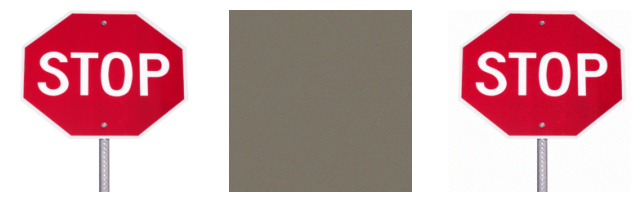

For epsilon:0.5 [Prediction = doormat, welcome mat, Confidence = 15.453353881835938, label_id =  539]
The predicition was wrong for epsilon = 0.5


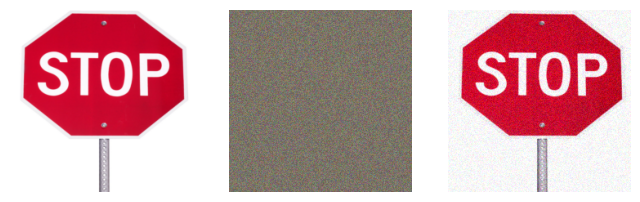

For epsilon:1 [Prediction = doormat, welcome mat, Confidence = 15.810676574707031, label_id =  539]
The predicition was wrong for epsilon = 1


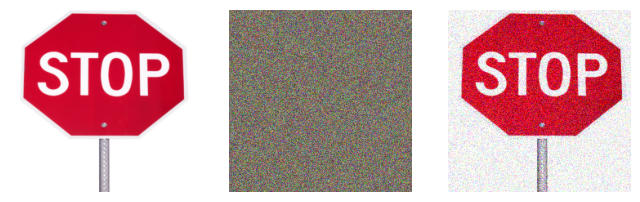

In [9]:
from scratchai import *
epsilon = (0.1,0.5,1)
torch.manual_seed(0)
np.random.seed(0)

for eps in epsilon:
    noisy_img = attacks.noise(img, eps=eps)
    output = get_prediction(noisy_img, resnet)
    print(f'For epsilon:{eps} [Prediction = {output[0]}, Confidence = {output[1]}, label_id =  {output[2]}]')
    if output[0] != 'street sign':
        print(f'The predicition was wrong for epsilon = {eps}')
    imgutils.imshow([img, noisy_img-img, noisy_img], normd=True)


As seen above, we got incorrect prediction for epislon values 0.5 and 1.

**1c: FGM Attack**

In [10]:
torch.manual_seed(0)
np.random.seed(0)

image_path =  stop_sign_path

images, true_labels, predicted_labels = one_call.attack(image_path, atk = attacks.FGM, nstr = 'resnet18', ret=True)

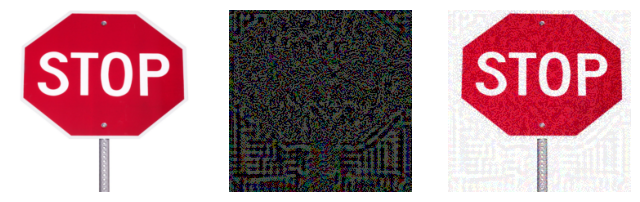

The original image     	 The adversarial perturbation 	    The perturbed image


In [11]:
imgutils.imshow(images)
print('The original image     \t The adversarial perturbation \t    The perturbed image')

In [12]:
true_labels, predicted_labels

(('street sign', 13.558084487915039),
 ('doormat, welcome mat', 14.281638145446777))

In [13]:
print(f'ResNet-18 prediction on this adversarial example: {predicted_labels[0]}')
print(f'ResNet-18 confidence on this adversarial example: {predicted_labels[1]}')

ResNet-18 prediction on this adversarial example: doormat, welcome mat
ResNet-18 confidence on this adversarial example: 14.281638145446777


**1d: PGD Attack**

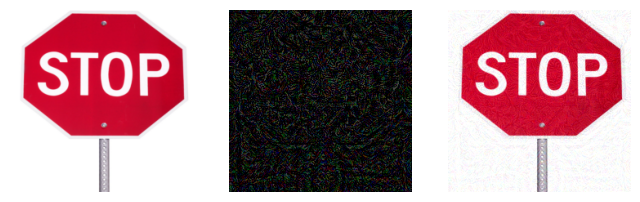

The original image     	 The adversarial perturbation 	    The perturbed image


In [14]:
torch.manual_seed(0)
np.random.seed(0)
target_class = 829

images, true_labels, predicted_labels = one_call.attack(image_path, atk = attacks.PGD, nstr = 'resnet18', ret=True)

imgutils.imshow(images)
print('The original image     \t The adversarial perturbation \t    The perturbed image')

In [15]:
true_labels, predicted_labels

(('street sign', 13.558084487915039),
 ('jersey, T-shirt, tee shirt', 48.39384460449219))

In [16]:
print(f'ResNet-18 confidence on this adversarial example: {predicted_labels[1]}')

ResNet-18 confidence on this adversarial example: 48.39384460449219


**2a: AlexNet layer 0 visualization**

In [17]:
torch.manual_seed(0)
np.random.seed(0)

alexnet = models.alexnet(pretrained=True).eval()
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

C:\Users\Sriram\anaconda3\envs\py37_ta\lib\site-packages\torch\nn\modules\module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


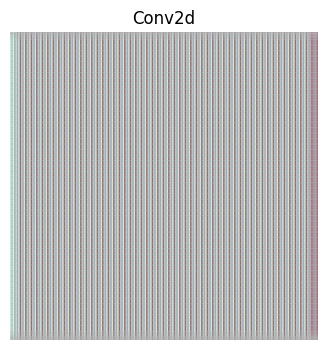

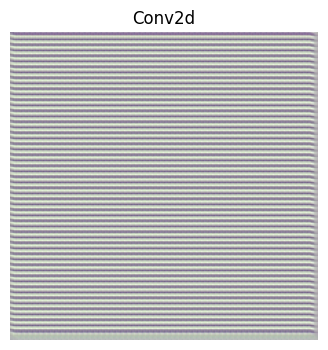

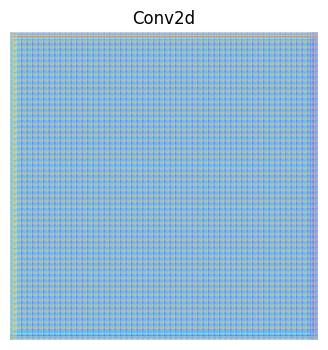

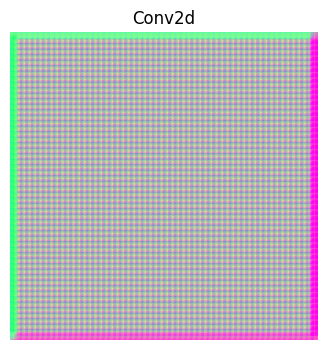

In [18]:
#load GradientAscent on GPU
g_ascent = GradientAscent(alexnet.features)
g_ascent.use_gpu = True

layer_idx = 0

for filters in [5,10,15,20]:
    layer = alexnet.features[layer_idx]
    g_ascent.visualize(layer, filters)


**2b: AlexNet layer 10 visualization**

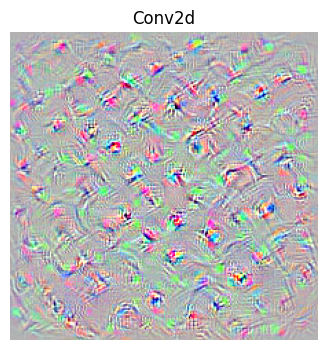

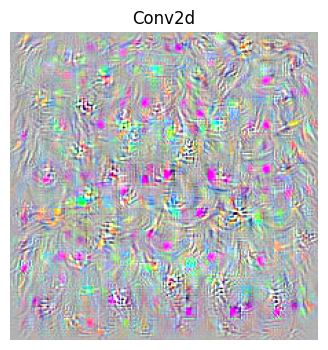

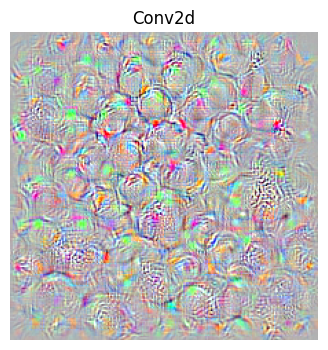

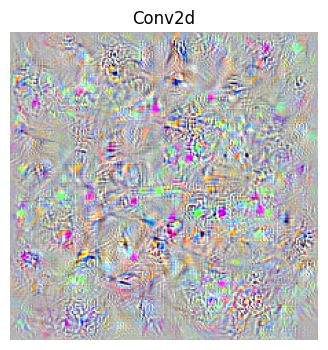

In [19]:
layer_idx = 10

for filters in [5,10,15,20]:
    layer = alexnet.features[layer_idx]
    g_ascent.visualize(layer, filters)

**2c: AlexNet saliency map with the stop sign image**

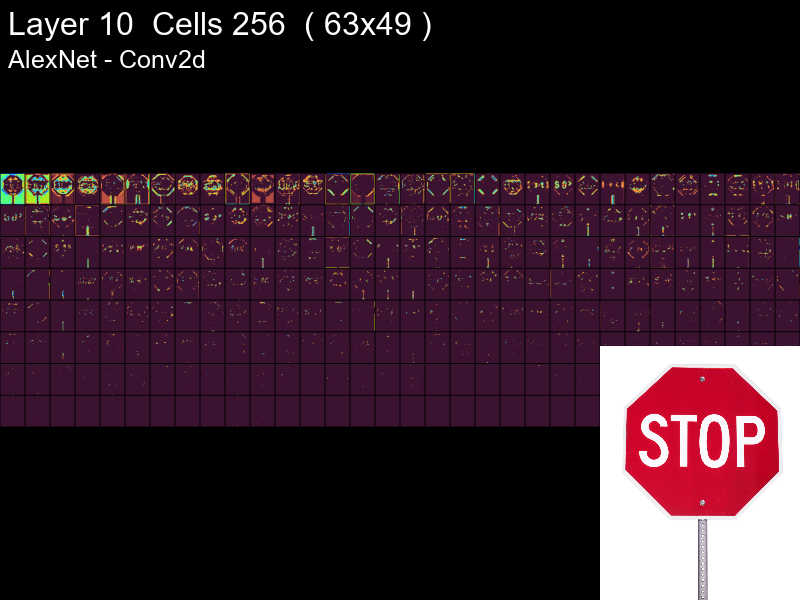

In [20]:
torch.manual_seed(0)
np.random.seed(0)
from MapExtrackt import FeatureExtractor

layer_idx = 10

fe = FeatureExtractor(alexnet)

fe.set_image(stop_sign_path) # stop_sign_path is the path to the stop sign image

fe.display_from_map(layer_no=layer_idx)

**3: Example of plot with a confidence interval**

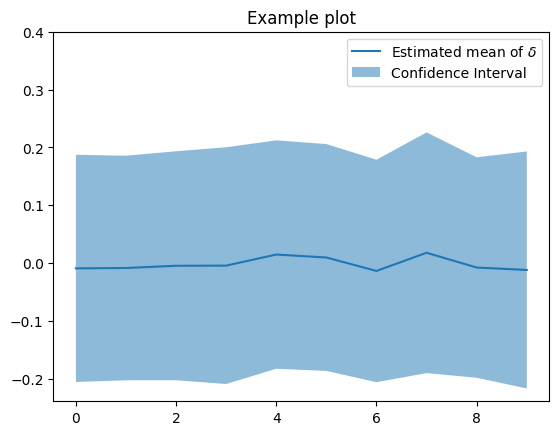

In [21]:
#THIS IS JUST AN EXAMPLE TO PLOT CONFIDENCE INTERVAL AS SHADED AREA

torch.manual_seed(0)
np.random.seed(0)

n = 500 # number of samples
k = 10  # number of replications
sigma = 0.2

torch.manual_seed(0) # set the random seed
deltas = torch.FloatTensor(sigma*torch.randn(n, k)) # gaussian samples ~ N(0, sigma*I)

# compute mean and standard deviation
mean_ = deltas.mean(dim=0)
std_ = deltas.std(dim=0)

# generate the plot
x = np.arange(k) # populate x axis
plt.plot(x, mean_, label="Estimated mean of $\delta$")
plt.fill_between(x, mean_ - std_, mean_ + std_, alpha=0.5, label="Confidence Interval") # 1-sigma confidence interval
plt.legend()
plt.ylim([None, 0.4])
plt.title('Example plot')
plt.show()

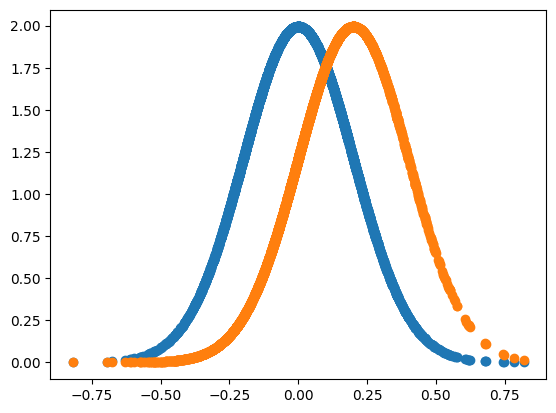

In [22]:
# THIS IS AN EXAMPLE TO USE log_prob METHOD FOR EASIER DENSITY COMPUTATION

# Suppose you want to compute the density of Normal distribution

# create Normal distribution object
p = Normal(torch.tensor([0.0]), torch.tensor([sigma]))       # N(0, sigma**2)
p_tilde = Normal(torch.tensor([0.2]), torch.tensor([sigma])) # N(1, sigma**2)

# use log_prob method
log_density_orig = p.log_prob(deltas) # log_prob method gives you log densities
log_density_tilde = p_tilde.log_prob(deltas)

# verify this by plotting the density, i.e. the exp of the log_density
plt.scatter(deltas, torch.exp(log_density_orig), label="p")
plt.scatter(deltas, torch.exp(log_density_tilde), label="p_tilde")
plt.show()

**3a: MC estimator for prob. robustness of ResNet-18**


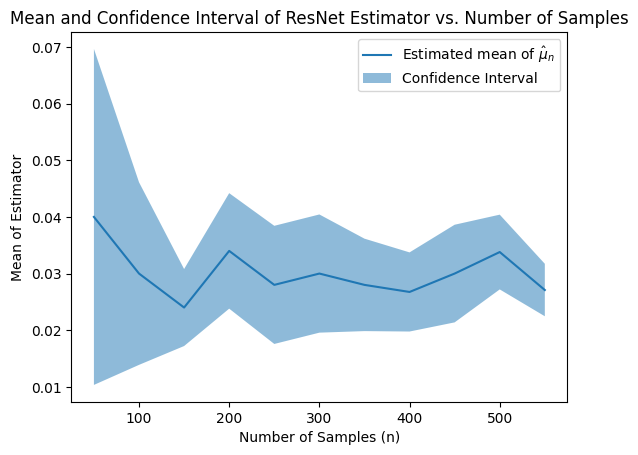

In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

resnet = models.resnet18(pretrained=True).eval()

net = resnet

sigma_squared = 0.2 # parameter sigma

# Number of replications and samples
k = 10 # number of replications
n_values = list(range(50, 551, 50))  # number of samples in each replication
resnet_results = []

for n in n_values:
    torch.manual_seed(0)
    deltas = torch.FloatTensor(sigma_squared * torch.randn(*img.shape, n, k))

    resnet_test = np.zeros([n, k])

    for i in range(k):
        for j in range(n):
            noisy_img = img + deltas[:, :, :, j, i]
            _, _, y_i = get_prediction(noisy_img, net)
            resnet_test[j, i] = y_i != true_class
    misclassification_rate = (resnet_test.sum(axis=0) / n).tolist()
    mu_hat_n_samples = resnet_test.mean(axis=0)
    resnet_results.append(mu_hat_n_samples)

# Compute mean and standard deviation for each n
means = [result.mean() for result in resnet_results]
stds = [result.std() for result in resnet_results]

# Generate the plot
x = np.array(n_values)

plt.plot(x, means, label="Estimated mean of $\hat{\mu}_n$")
plt.fill_between(x, np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.5, label="Confidence Interval")  # 1-sigma confidence interval
plt.xlabel('Number of Samples (n)')
plt.ylabel('Mean of Estimator')
plt.title('Mean and Confidence Interval of ResNet Estimator vs. Number of Samples')
plt.legend()
plt.show()



**3b: MC relative error**

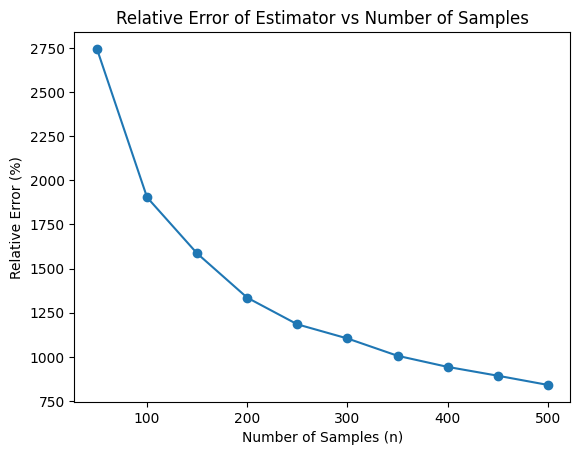

In [24]:
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

# True value
mu = 0.03

# Function to compute the relative error
def compute_relative_error(estimator_values, true_value):
    mean_estimator = np.mean(estimator_values)
    std_estimator = np.std(estimator_values, ddof=1)  # ddof=1 for unbiased estimator of the variance
    relative_error = std_estimator / mean_estimator
    relative_error_percentage = (relative_error / true_value) * 100
    return relative_error_percentage

# Number of replications
k = 1000  # you can adjust this value based on your needs

# List to store relative errors for different n values
relative_errors = []

# Iterate over different sample sizes n
for n in range(50, 501, 50):
    # Generate n i.i.d. samples and compute the estimator
    estimator_values = np.zeros(k)
    for i in range(k):
        deltas = sigma_squared * np.random.randn(n)
        noisy_predictions = np.random.choice([True, False], size=n, p=[mu, 1 - mu])
        estimator_values[i] = np.mean(noisy_predictions)

    # Compute relative error and store it
    relative_error = compute_relative_error(estimator_values, mu)
    relative_errors.append(relative_error)

# Plot the relative error vs n
plt.plot(range(50, 501, 50), relative_errors, marker='o')
plt.xlabel('Number of Samples (n)')
plt.ylabel('Relative Error (%)')
plt.title('Relative Error of Estimator vs Number of Samples')
plt.show()


In [36]:
import torch
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

resnet = models.resnet18(pretrained=True).eval()

net = resnet

sigma_squared = 0.2 # parameter sigma
xtilde= one_call.attack(image_path, atk=attacks.FGM, nstr='resnet18', ret=True)[0][2]
scale = 1/3
mean_shift = scale * xtilde

# Number of replications and samples
k = 10 # number of replications
n_values = list(range(50, 551, 50))  # number of samples in each replication
resnet_results = []


for n in n_values:
    torch.manual_seed(0)
    deltas = torch.FloatTensor(mean_shift.unsqueeze(-1).unsqueeze(-1) + sigma_squared * torch.randn(*img.shape, n, k))

    resnet_test = np.zeros([n, k])

    for i in range(k):
        for j in range(n):
            noisy_img = img + deltas[:, :, :, j, i]
            _, _, y_i = get_prediction(noisy_img, net)
            resnet_test[j, i] = y_i != true_class
    misclassification_rate = (resnet_test.sum(axis=0) / n).tolist()




In [48]:
misclassification_rate

[0.4709090909090909,
 0.44545454545454544,
 0.49818181818181817,
 0.4763636363636364,
 0.4672727272727273,
 0.46545454545454545,
 0.46,
 0.49818181818181817,
 0.5236363636363637,
 0.4636363636363636]

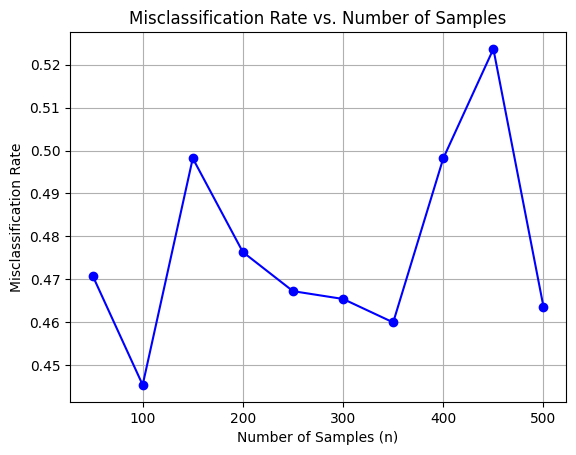

In [46]:
x = np.array(n_values[:-1])
y = np.array(misclassification_rate)

# Generate the plot
plt.plot(x, y, marker='o', linestyle='-', color='b')  # Add markers for each point
plt.xlabel('Number of Samples (n)')
plt.ylabel('Misclassification Rate')
plt.title('Misclassification Rate vs. Number of Samples')
plt.grid(True)
plt.show()